# Spatial autocorrelation

In the last section, you learned how to encode spatial relationships
between geometries into weights matrices represented by `Graph` objects
and started touching on spatial autocorrelation with spatial lag and
Moran plot. This section explores spatial autocorrelation further in its
global and local variants.

Spatial autocorrelation has to do with the degree to which the
similarity in values between observations in a dataset is related to the
similarity in locations of such observations. Not completely unlike the
traditional correlation between two variables -which informs us about
how the values in one variable change as a function of those in the
other- and analogous to its time-series counterpart -which relates the
value of a variable at a given point in time with those in previous
periods-, spatial autocorrelation relates the value of the variable of
interest in a given location with values of the same variable in
surrounding locations.

A key idea in this context is that of spatial randomness: a situation in
which the location of observation gives no information whatsoever about
its value. In other words, a variable is spatially random if it is
distributed following no discernible pattern over space. Spatial
autocorrelation can thus be formally defined as the “absence of spatial
randomness”, which gives room for two main classes of autocorrelation,
similar to the traditional case: *positive* spatial autocorrelation,
when similar values tend to group together in similar locations; and
*negative* spatial autocorrelation, in cases where similar values tend
to be dispersed and further apart from each other.

In this session, you will learn how to explore spatial autocorrelation
in a given dataset, interrogating the data about its presence, nature,
and strength. To do this, you will use a set of tools collectively known
as Exploratory Spatial Data Analysis (ESDA), specifically designed for
this purpose. The range of ESDA methods is very wide and spans from less
sophisticated approaches like choropleths and general table querying to
more advanced and robust methodologies that include statistical
inference and explicit recognition of the geographical dimension of the
data. The purpose of this session is to dip your toes into the latter
group.

ESDA techniques are usually divided into two main groups: tools to
analyse *global*, and *local* spatial autocorrelation. The former
considers the overall trend that the location of values follows and
makes possible statements about the degree of *clustering* in the
dataset. *Do values generally follow a particular pattern in their
geographical distribution*? *Are similar values closer to other similar
values than you would expect from pure chance?* These are some of the
questions that tools for global spatial autocorrelation allow to answer.
You will practice with global spatial autocorrelation on the Join Counts
statistic and Moran’s $I$ statistic.

Tools for *local* spatial autocorrelation instead focus on spatial
instability: the departure of parts of a map from the general trend. The
idea here is that, even though there is a given trend for the data in
terms of the nature and strength of spatial association, some particular
areas can diverge quite substantially from the general pattern.
Regardless of the overall degree of concentration in the values, you can
observe pockets of unusually high (low) values close to other high (low)
values in what you will call hot (cold) spots. Additionally, it is also
possible to observe some high (low) values surrounded by low (high)
values, and you will name these “spatial outliers”. The main technique
you will review in this session to explore local spatial autocorrelation
is the Local Indicators of Spatial Association (LISA).

In [ ]:
import geopandas as gpd
import esda
import matplotlib.pyplot as plt
import seaborn as sns

from libpysal import graph

## Data

For this session, you will look at the election data. In particular, the
results of the second round of the presidential elections in Czechia in
2023, between Petr Pavel and Andrej Babiš, on a level of municipalities.
Each polygon has a percentage of votes for either of the candidates
attached, as well as some additional information. Election data are
provided by the [Czech Statistical Office](https://www.volby.cz), and
geometries are retrieved from [ČÚZK](https://www.cuzk.cz). The dataset
is preprocessed for the purpose of this course. If you want to see how
the table was created, a notebook is available
[here](../data/cz_elections_2023/preprocessing.ipynb).

To make things easier, you will read data from a file posted online, so
you do not need to download any dataset:

In [ ]:
elections = gpd.read_file(
    "https://martinfleischmann.net/sds/autocorrelation/data/cz_elections_2023.gpkg"
)
elections = elections.set_index("name")
elections.explore(
    "PetrPavel",
    cmap="coolwarm",
    vmin=0,
    vmax=100,
    prefer_canvas=True,
    tiles="CartoDB Positron",
)

> **Alternative**
>
> Instead of reading the file directly off the web, it is possible to
> download it manually, store it on your computer, and read it locally.
> To do that, you can follow these steps:
>
> 1.  Download the file by right-clicking on [this
>     link](https://martinfleischmann.net/sds/autocorrelation/data/cz_elections_2023.gpkg)
>     and saving the file
> 2.  Place the file in the same folder as the notebook where you intend
>     to read it
> 3.  Replace the code in the cell above with:
>
> ``` python
> elections = gpd.read_file(
>     "cz_elections_2023.gpkg",
> )
> ```

## Spatial weights refresher

You already know how to work with the spatial weights matrices from the
previous session. In this case, you will need to create queen contiguity
weights, which consider two observations as neighbours if they share at
least one point of their boundary. In other words, for a pair of
municipalities in the dataset to be considered neighbours under this
$W$, they must be sharing borders or “touching” each other to some
degree.

Technically speaking, you will approach building the contiguity matrix
in the same way you did before. You will begin with a `GeoDataFrame` and
pass it on to the queen contiguity weights builder in `libpysal`. You
will also make sure your table of data is previously indexed on the
municipality name, so the $W$ is also indexed on that form.

In [ ]:
contiguity = graph.Graph.build_contiguity(elections, rook=False)

Now, the `contiguity` object you have is the same type as any other one
you have created. As such, you can inspect it in the same way. For
example, you can check who is a neighbour of observation `Hrazany`:

In [ ]:
contiguity["Hrazany"]

Since you will be dealing with spatial lags, it may be wise to
row-standardise the matrix.

In [ ]:
contiguity_r = contiguity.transform("r")

Now, because you have row-standardize them, the weight given to each of
the five neighbours is 0.2, which equals one.

In [ ]:
contiguity_r["Hrazany"]

## Spatial lag refresher

You also know what spatial lag is. Once you have the data and the
spatial weights matrix ready, you can start by computing the spatial lag
of the percentage of votes that went to the winning candidate, Petr
Pavel. Remember that the spatial lag is the product of the spatial
weights matrix and a given variable. If $W$ is row-standardized, the
result amounts to the average value of the variable in the neighbourhood
of each observation.

We can calculate the spatial lag for the variable `"PetrPavel"` and
store it directly in the main table with the following line of code:

In [ ]:
elections['PP_lag'] = contiguity_r.lag(elections["PetrPavel"])
elections.head()

The way to interpret the spatial lag (`PP_lag`) for, say, the first
observation is as follows: Abertamy, where Petr Pavel received 62.98%,
is surrounded by neighbouring municipalities where, on average, more
than 65% of the electorate also voted for him. For the purpose of
illustration, you can, in fact, check this is correct by querying the
spatial weights matrix to find out Abertamy’s neighbours:

In [ ]:
contiguity_r['Abertamy']

And then checking their values:

In [ ]:
neis = elections.loc[contiguity_r['Abertamy'].index, "PetrPavel"]
neis

And the average value, which you saw in the spatial lag is 65.56, can be
calculated as follows:

In [ ]:
neis.mean()

For some of the techniques you will see below, it makes more sense to
operate with the standardised version of a variable rather than the raw
one. Standardising means subtracting the average value and dividing it
by the standard deviation.

$$
z_i = \dfrac{y - \bar{y}}{\sigma_y}
$$

where $z_i$ is the standardized version of $y_i$, $\bar{y}$ is the
average of the variable, and $\sigma$ its standard deviation.

This can be done easily with a bit of basic algebra in `pandas`:

In [ ]:
elections["PP_std"] = (
    elections["PetrPavel"] - elections["PetrPavel"].mean()
) / elections["PetrPavel"].std()

Finally, to be able to explore the spatial patterns of the standardised
values, also called sometimes $z$ values, you need to create its spatial
lag:

In [ ]:
elections["PP_std_lag"] = contiguity_r.lag(elections["PP_std"])

## Global spatial autocorrelation

Spatial autocorrelation is measured differently depending on the type of
data. For boolean (True or False) variables, you can use the Join Counts
statistic, while for continuous variables, you can use Moran’s $I$.
Let’s start with the boolean case.

### Join Counts for boolean variables

The `elections` dataset does not contain any boolean variable, but it is
easy to create one representing whether Petr Pavel lost in a
municipality or not.

In [ ]:
elections["PP_winner"] = (elections["PetrPavel"] < 50).astype(int)
elections.head()

You will be dealing with data that looks something like this now:

In [ ]:
_ = elections.plot("PP_winner", cmap="binary", linewidth=.1, edgecolor="grey")

Since you are looking for spatial autocorrelation, you can already guess
this will be a clear case since there are large clusters of black and
white municipalities. However, your (even educated) guess is not enough.
Instead, you can use the Join Count statistic. Its principle is simple.
Given a checkboard with black (0) and white (1) cells, you can count how
many times black is next to another black (BB), how many times white is
next to white (WW) and how many times there are black-white
relationships (BW). The prevalence of BB and WW indicates positive
autocorrelation, while the prevalence of BW indicates a negative one.
The significance is then derived from comparing how many BB, WW and BW
occurrences you could expect under complete spatial randomness.

The weights for Join Counts are expected to be binary. So you could
either use the original `contiguity` weights, which are binary by
default, or transform `contiguity_r` to binary. You can then measure the
statistics using the `Join_Counts` class from `esda`.

In [ ]:
jc = esda.Join_Counts(
    elections["PP_winner"],
    contiguity
)

The results are all stored in the `jc` object. You can ask for the
observed number of black-black relations:

In [ ]:
jc.bb

Or for white-white relations.

In [ ]:
jc.ww

And the remaining black-white relations.

In [ ]:
jc.bw

The total number of joins, composed of all three options summed
together, is available as `.J`.

In [ ]:
jc.J

The key aspect of the statistic is the comparison of the number of
observed BB and BW joins with that coming from simulated randomness. If
the variable was purely random, the number of BB joins would be roughly:

In [ ]:
jc.mean_bb

And the number of BW joins would be:

In [ ]:
jc.mean_bw

Given the simulated values are nowhere close to the observed counts, you
can assume an existence of positive spatial autocorrelation. You can
also retrieve the simulated pseudo-$p$-values indicating significance:

In [ ]:
jc.p_sim_bb

> **More information from `Join_Counts`**
>
> The `Join_Counts` class includes much more than these. Explore them
> yourself!

### Moran Plot

When dealing with continuous variables, the first indication of spatial
autocorrelation can be obtained using the Moran plot.The Moran Plot is a
graphical way to start exploring the concept of spatial autocorrelation,
and it is a good application of spatial weight matrices and the spatial
lag. In essence, it is a standard scatter plot in which a given variable
(`area`, for example) is plotted against *its own* spatial lag. Usually,
a fitted line is added to include more information. In order to easily
compare different scatter plots and spot outlier observations, it
ismcommon practice to standardise the values of the variable before
computing its spatial lag and plotting it. Let’s have a look at what it
looks like in this case based on the standardised values you made above.

In [ ]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x="PP_std",
    y="PP_std_lag",
    data=elections,
    marker=".",
    scatter_kws={"alpha": 0.2},
    line_kws=dict(color="lightcoral")
)
ax.set_aspect('equal')
plt.axvline(0, c="black", alpha=0.5)
plt.axhline(0, c="black", alpha=0.5)
plt.text(2.3, 2.7, "High-high", fontsize=10)
plt.text(2.3, -2.7, "High-low", fontsize=10)
plt.text(-4.4, 2.7, "Low-high", fontsize=10)
plt.text(-4.4, -2.7, "Low-low", fontsize=10);

Creating a standardised Moran Plot implies that average values are
centred in the plot (as they are zero when standardised), and dispersion
is expressed in standard deviations, with the rule of thumb of values
greater or smaller than two standard deviations being *outliers*. A
standardised Moran Plot also partitions the space into four quadrants
that represent different situations:

1.  High-High (*HH*): values above average surrounded by values above
    average.
2.  Low-Low (*LL*): values below average surrounded by values below
    average.
3.  High-Low (*HL*): values above average surrounded by values below
    average.
4.  Low-High (*LH*): values below average surrounded by values above
    average.

The figure above displays the relationship between the standardised
percentage that voted for Petr Pavel (`"PP_std"`) and its spatial lag,
which, because the $W$ that was used is row-standardized, can be
interpreted as the average percentage that voted to Petr Pavel in the
surrounding areas of a given municipality. In order to guide the
interpretation of the plot, a linear fit is also included in the post.
This line represents the best linear fit to the scatter plot or, in
other words, the best way to represent the relationship between the two
variables as a straight line.

The plot displays a positive relationship between both variables. This
is associated with the presence of *positive* spatial autocorrelation:
similar values tend to be located close to each other. This means that
the *overall trend* is for high values to be close to other high values,
and for low values to be surrounded by other low values. This, however,
does not mean that this is only situation in the dataset: there can, of
course, be particular cases where high values are surrounded by low
ones, and vice versa. But it means that if you had to summarise the main
pattern of the data in terms of how clustered similar values are, the
best way would be to say they are positively correlated and, hence,
clustered over space.

In the context of the example, this can be interpreted along the lines
of: municipalities display positive spatial autocorrelation in the way
they voted in the presidential elections. This means that municipalities
with a high percentage of Pavel’s voters tend to be located near other
municipalities where a significant share of the electorate also voted
for him and vice versa.

### Moran’s $I$

The Moran Plot is an excellent tool to explore the data and understand
to which degree values are clustered over space. However, because it is
a graphical device, it is sometimes hard to concisely condense its
insights. For these cases, a good approach is to come up with a
statistical measure that summarises the figure. This is exactly what
Moran’s $I$ is meant to do.

Very much in the same way the mean summarises a crucial element of the
distribution of values in a non-spatial setting, so does Moran’s $I$ for
a spatial dataset. Continuing the comparison, you can think of the mean
as a single numerical value summarising a histogram or a kernel density
plot. Similarly, Moran’s $I$ captures much of the essence of the Moran
Plot. In fact, there is an even closer connection between the two: the
value of Moran’s $I$ corresponds with the slope of the linear fit
overlayed on top of the Moran Plot.

In order to calculate Moran’s $I$ in your dataset, you can call a
specific function in PySAL’s `esda` package directly:

In [ ]:
mi = esda.Moran(elections['PetrPavel'], contiguity_r)

The class `esda.Moran` creates an object that contains much more
information than the actual statistic. If you want to retrieve the value
of the statistic, you can do it this way:

In [ ]:
mi.I

The other bit of information you will extract from Moran’s $I$ relates
to statistical inference: How likely is the pattern you observe in the
map and Moran’s $I$ captures in its value to be generated by an entirely
random process? If you consider the same variable but shuffled its
locations randomly, would you obtain a map with a similar
characteristics?

The specific details of the mechanism to calculate this are beyond the
scope of the session, but it is important to know that a small enough
$p$-value associated with the Moran’s $I$ of a map allows you to reject
the hypothesis that the map is random. In other words, you can conclude
that the map displays more spatial patterns than you would expect if the
values had been randomly allocated to a particular location.

The most reliable $p$-value for Moran’s $I$ can be found in the
attribute `.p_sim`:

In [ ]:
mi.p_sim

That is just 0.1%, and, by standard terms, it would be considered
statistically significant. You can quickly elaborate on its intuition.
What that 0.001 (or 0.1%) means that if you generated a large number of
maps with the same values but randomly allocated over space, and
calculated the Moran’s $I$ statistic for each of those maps, only 0.1%
of them would display a larger (absolute) value than the one you obtain
from the real data and the other 99.9% of the random maps would receive
a smaller (absolute) value of Moran’s $I$. If you remember again, the
value of Moran’s $I$ can also be interpreted as the slope of the Moran
Plot, what you have is that, in this case, the particular spatial
arrangement of values for Pavel’s votes is more concentrated than if the
values had been allocated following a completely spatially random
process, hence the statistical significance.

As a first step, the global autocorrelation analysis can teach us that
observations do seem to be positively correlated over space. In terms of
your initial goal to find spatial structure in the attitude towards
elections, this view seems to align: if the vote had no such structure;
it should not show a pattern over space -technically, it would show a
random one.

## Local Spatial autocorrelation

Moran’s $I$ is a good tool to summarise a dataset into a single value
that informs about its degree of *clustering*. However, it is not an
appropriate measure to identify areas within the map where specific
values are located. In other words, Moran’s $I$ can tell us values are
clustered overall, but it will not inform us about *where* the clusters
are. For that purpose, you need to use a *local* measure of spatial
autocorrelation. Local measures consider every single observation in a
dataset and operate on them, as opposed to on the overall data, as
*global* measures do. Because of that, they are not good at summarising
a map, but they allow you to obtain further insight.

In this session, you will consider [Local Indicators of Spatial
Association](http://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.1995.tb00338.x/abstract)
(LISAs), a local counterpart of global measures like Moran’s $I$. At the
core of these methods is a classification of the observations in a
dataset into four groups derived from the Moran Plot: high values
surrounded by high values (HH), low values nearby other low values (LL),
high values among low values (HL), and vice versa (LH). Each of these
groups are typically called “quadrants”. An illustration of where each
of these groups falls into the Moran Plot can be seen in the
<a href="#fig-moran-plot" class="quarto-xref">Figure 1</a> above.

So far, you have classified each observation in the dataset depending on
its value and that of its neighbours. This is only halfway into
identifying areas of unusual concentration of values. To know whether
each of the locations is a *statistically significant* cluster of a
given kind, you again need to compare it with what you would expect if
the data were allocated in a completely random way. After all, by
definition, every observation will be of one kind or another, based on
the comparison above. However, what you are interested in is whether the
strength with which the values are concentrated is unusually high.

This is exactly what LISAs are designed to do. As before, a more
detailed description of their statistical underpinnings is beyond the
scope in this context, but you will try to shed some light on the
intuition of how they go about it. The core idea is to identify cases in
which the comparison between the value of an observation and the average
of its neighbours is either more similar (HH, LL) or dissimilar (HL, LH)
than you would expect from pure chance. The mechanism to do this is
similar to the one in the global Moran’s $I$, but applied in this case
to each observation, resulting in as many statistics as original
observations.

LISAs are widely used in many fields to identify clusters of values in
space. They are a very useful tool that can quickly return areas in
which values are concentrated and provide *suggestive* evidence about
the processes that might be at work. For that, they have a prime place
in the exploratory toolbox. Examples of contexts where LISAs can be
useful include identification of spatial clusters of poverty in regions,
detection of ethnic enclaves, delineation of areas of particularly
high/low activity of any phenomenon, etc.

In Python, you can calculate LISAs in a very streamlined way thanks to
`esda`:

In [ ]:
lisa = esda.Moran_Local(elections['PetrPavel'], contiguity_r)

All you need to pass is the variable of interest -the percentage of
Pavel’s votes- and the spatial weights that describe the neighbourhood
relations between the different observation that make up the dataset.

Because of their very nature, looking at the numerical result of LISAs
is not always the most useful way to exploit all the information they
can provide. Remember that you are calculating a statistic for every
observation in the data, so it will be difficult to extract any
meaningful pattern if you have many of them. Instead, what is typically
done is to create a map, a cluster map as it is usually called, that
extracts the significant observations (those that are highly unlikely to
have come from pure chance) and plots them with a specific col or
depending on their quadrant category.

All of the needed pieces are contained inside the `lisa` object you have
created above. But, to make the map-making more straightforward, it is
convenient to pull them out and insert them in the main data table,
`elections`:

In [ ]:
elections['cluster'] = lisa.get_cluster_labels(crit_value=0.05)
elections.head()

Similarly as with global Moran’s $I$, `esda` is automatically computing
a $p$-value for each LISA. Because not every observation represents a
statistically significant one, you want to identify those with a
$p$-value small enough that it rules out the possibility of obtaining a
similar situation from pure chance. Following a similar reasoning as
with global Moran’s $I$, you select 5% as the threshold for statistical
significance.

You can quickly map these results using the `explore()` method.

In [ ]:
lisa.explore(
  elections,
  crit_value=0.05,
  prefer_canvas=True,
  tiles="CartoDB Positron",
)

> **Static plot**
>
> The same map can be also plotted statically:
>
> ``` python
> _ = lisa.plot(
>   elections,
>   crit_value=0.05,
> )
> ```
>
> <figure>
> 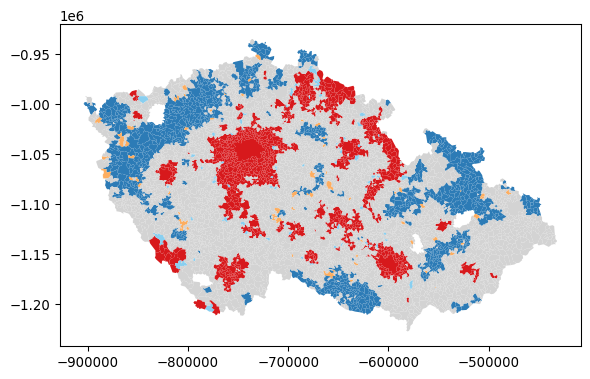 alt="Local clusters of LISA." />
> <figcaption aria-hidden="true">Local clusters of LISA.</figcaption>
> </figure>

You can also use use the `plot_scatter()` method to get a Moran Plot
linking the clusters to the scatterplot.

In [ ]:
_ = lisa.plot_scatter()

> **Plotting LISA manually**
>
> If you want to have more control over what is being displayed and how
> each component is presented, you can “cook” the plot by hand. The same
> will apply to interactive maps:
>
> ``` python
> f, ax = plt.subplots(1, figsize=(6, 6))
> elections.loc[elections["cluster"] == "Insignificant"].plot(ax=ax, color="lightgrey")
> elections.loc[(elections["cluster"] == "High-High")].plot(ax=ax, color="#d7191c")
> elections.loc[(elections["cluster"] == "Low-Low")].plot(ax=ax, color="#2c7bb6")
> elections.loc[(elections["cluster"] == "Low-High")].plot(ax=ax, color="#abd9e9")
> elections.loc[(elections["cluster"] == "High-Low")].plot(ax=ax, color="#fdae61");
> ```
>
> 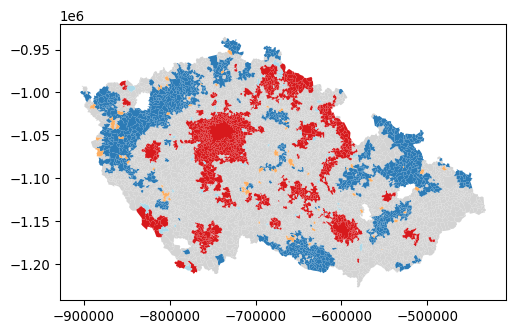

The map above displays the LISA results of the presidential elections.
In bright red, you find those municipalities with an unusual
concentration of high levels of Pavel’s voters also surrounded by high
levels of his voters. This corresponds with areas in the Prague
Metropolitan region, around other large cities like Pilsen or Brno and
some other areas. On the other hand, areas in the dark blue voted
against Pavel, similarly to their surrounding municipalities. In orange,
you find the first type of *spatial outliers*. These are areas with high
Pavel’s gain but surrounded by areas voting for Babiš (e.g. Mariánské
Lázně). Finally, in light blue, you find the other type of spatial
outlier: municipalities with low Pavel’s support surrounded by other
municipalities with high support.

The substantive interpretation of a LISA map needs to relate its output
to the original intention of the analyst who created the map. In this
case, your original idea was to explore the spatial structure of support
of Petr Pavel. The LISA proves a fairly useful tool in this context.
Comparing the LISA map above with the choropleth you started with, you
can interpret the LISA as a “simplification” of the detailed but perhaps
too complicated picture in the choropleth that focuses the reader’s
attention to the areas that display a particularly high concentration of
(dis)similar values, helping the spatial structure of the vote emerge
more explicitly. The result of this highlights the relevance that the
cities had in voting for Pavel, as well as the regions of the map where
there was a lot less excitement about him.

## Other options

Join counts and Moran’s methods are not the only ways of computing
spatial autocorrelation. `esda` offers way more, including [Geary’s
$C$](https://pysal.org/esda/generated/esda.Geary.html#esda.Geary),
[Getis-Ord $G$](https://pysal.org/esda/generated/esda.G.html#esda.G),
which can both be measured as global or local statistics, and other
methods, exposed in a similar way as those you have used today.

> **Additional reading**
>
> -   Have a look at the chapters [*Global Spatial
>     Autocorrelation*](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html#)
>     and [*Local Spatial
>     Autocorrelation*](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html)
>     from the Geographic Data Science with Python by @rey2023geographic
>     for more details and some other extensions.

## Acknowledgements

This section is derived from *A Course on Geographic Data Science* by
@darribas_gds_course, licensed under CC-BY-SA 4.0. The code was updated
to use the new `libpysal.graph` module instead of `libpysal.weights`.
The text was slightly adapted to accommodate a different dataset, the
module change, and the inclusion of Join counts.